In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Data 
Pulling the PJM East which has data from 2002-2018 for the entire east region.

In [3]:
pjme = pd.read_csv('../input/hourly-energy-consumption/PJME_hourly.csv')

In [4]:
pjme.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [5]:
pjme.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


# Data Exploration
* Understand the structure of your dataset, including columns, data types, and the time range covered.
* Plot time series visualizations to observe patterns, trends, and potential seasonality in the hourly energy consumption data.

In [6]:
# Convert the timestamp column to a Pandas datetime object
pjme['Datetime'] = pd.to_datetime(pjme['Datetime'])

# Display the minimum and maximum dates in the dataset
print("Minimum Date:", pjme['Datetime'].min())
print("Maximum Date:", pjme['Datetime'].max())

Minimum Date: 2002-01-01 01:00:00
Maximum Date: 2018-08-03 00:00:00


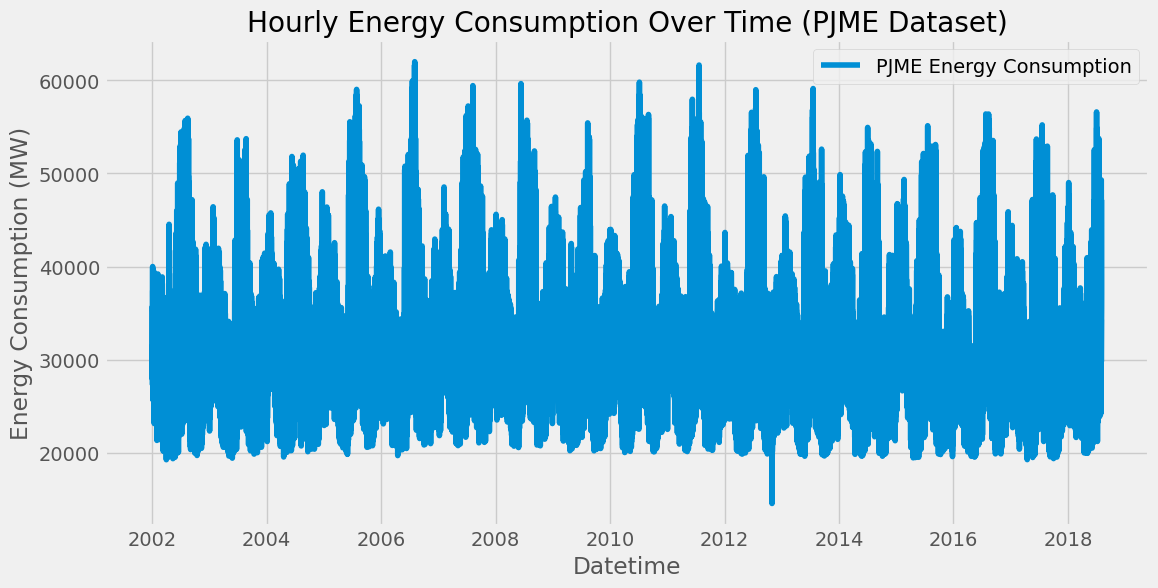

In [7]:
# Plot the entire time series
plt.figure(figsize=(12, 6))
plt.plot(pjme['Datetime'], pjme['PJME_MW'], label='PJME Energy Consumption')
plt.title('Hourly Energy Consumption Over Time (PJME Dataset)')
plt.xlabel('Datetime')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.show()

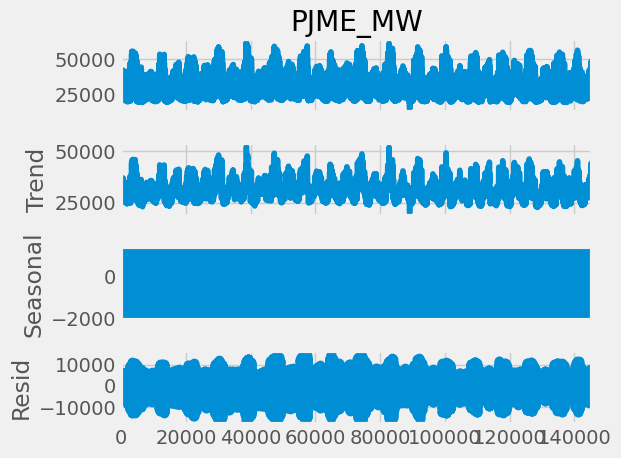

In [8]:
#Decompose the time series into trend, seasonality, and residual components for a more detailed analysis.

from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
result = seasonal_decompose(pjme['PJME_MW'], model='additive', period=24)  # Assuming daily seasonality

# Plot the decomposed components
result.plot()
plt.show()

# Data Preprocessing
* Check for missing values in the dataset and decide on an appropriate strategy for handling them.
* Ensure that your data is in the required format for Prophet, with columns "ds" for dates and "y" for the target variable (energy consumption).

In [9]:
# Check for missing values
missing_values = pjme.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 Datetime    0
PJME_MW     0
dtype: int64


In [10]:
# Set Datetime as the index
pjme.set_index('Datetime', inplace=True)

In [11]:
# use the last 20% of the data as the test set
split_date = int(len(pjme) * 0.8)
train_data = pjme.iloc[:split_date]
test_data = pjme.iloc[split_date:]

Our dataset is preprocessed and ready for modeling. We have handled missing values, set the datetime column as the index, and split it into training and testing sets.

# Data Transformation
Prophet model, it expects the input DataFrame to have columns named "ds" for the timestamps and "y" for the target variable. Let's create a new DataFrame named prophet_df with these columns and convert the timestamp to the appropriate format

In [12]:
prophet_df = pjme.reset_index().rename(columns={'Datetime': 'ds', 'PJME_MW': 'y'})

# Display the first few rows of the new DataFrame
prophet_df.head()

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


# Model Training
Split our data into training and testing sets. Use the training set to train the # Prophet model.

07:30:24 - cmdstanpy - INFO - Chain [1] start processing
07:31:42 - cmdstanpy - INFO - Chain [1] done processing


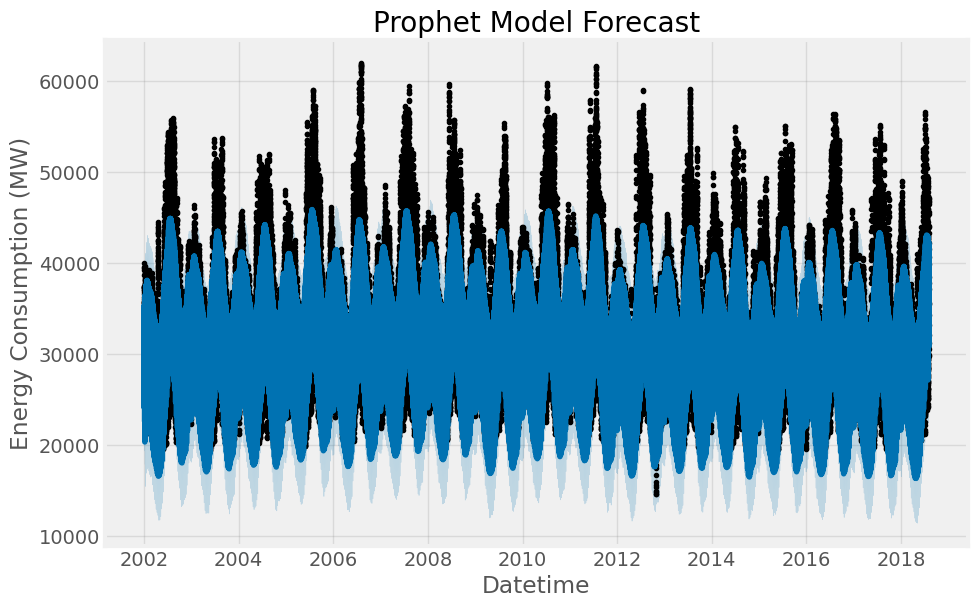

In [13]:
# Instantiate the Prophet model
model = Prophet()

# Fit the model to the training data
model.fit(prophet_df)

# Specify the number of hours to forecast into the future
future = model.make_future_dataframe(periods=24, freq='H')  # forecast 24 hours into the future

# Generate the forecast
forecast = model.predict(future)

# Display a summary of the forecast
model.plot(forecast)
plt.title('Prophet Model Forecast')
plt.xlabel('Datetime')
plt.ylabel('Energy Consumption (MW)')
plt.show()

# Validation and Evaluation
* Split your dataset into training and testing sets. Train the model on the training set and evaluate its performance on the testing set.
* Use evaluation metrics like Mean Absolute Error (MAE), Mean Squared Error (MSE), or Root Mean Squared Error (RMSE) to assess the model's accuracy.

In [14]:
# Use a train-test split (80% training, 20% testing)
split_date = int(len(pjme) * 0.8)
train_data = pjme.iloc[:split_date]
test_data = pjme.iloc[split_date:]

In [16]:
# Create a DataFrame with columns "ds" and "y" for Prophet using the training set
train_prophet_df = train_data.reset_index().rename(columns={'Datetime': 'ds', 'PJME_MW': 'y'})

In [17]:
# Instantiate the Prophet model and fit it to the training set
model = Prophet()
model.fit(train_prophet_df)

07:33:56 - cmdstanpy - INFO - Chain [1] start processing
07:35:05 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Specify the number of hours to forecast into the future for the testing set
future_test = model.make_future_dataframe(periods=len(test_data), freq='H')

In [19]:
# Generate the forecast for the testing set
forecast_test = model.predict(future_test)

In [20]:
# Extract actual and predicted values for the testing set
y_true = test_data['PJME_MW'].values
y_pred = forecast_test['yhat'][-len(test_data):].values

In [23]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = sqrt(mse)

In [24]:
# Display the evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 7698.492095714688
Mean Squared Error (MSE): 97698361.24993993
Root Mean Squared Error (RMSE): 9884.248137817056


# Time Series Features

In [25]:
# Specify the number of periods for each frequency
periods_monthly = 12  # 12 months
periods_weekly = 52   # 52 weeks
periods_daily = 30    # 30 days

In [26]:
# Create future DataFrames at different frequencies
future_monthly = model.make_future_dataframe(periods=periods_monthly, freq='MS')  # Monthly forecast
future_weekly = model.make_future_dataframe(periods=periods_weekly, freq='W')     # Weekly forecast
future_daily = model.make_future_dataframe(periods=periods_daily, freq='D')        # Daily forecast

In [27]:
# Generate forecasts at each frequency
forecast_monthly = model.predict(future_monthly)
forecast_weekly = model.predict(future_weekly)
forecast_daily = model.predict(future_daily)

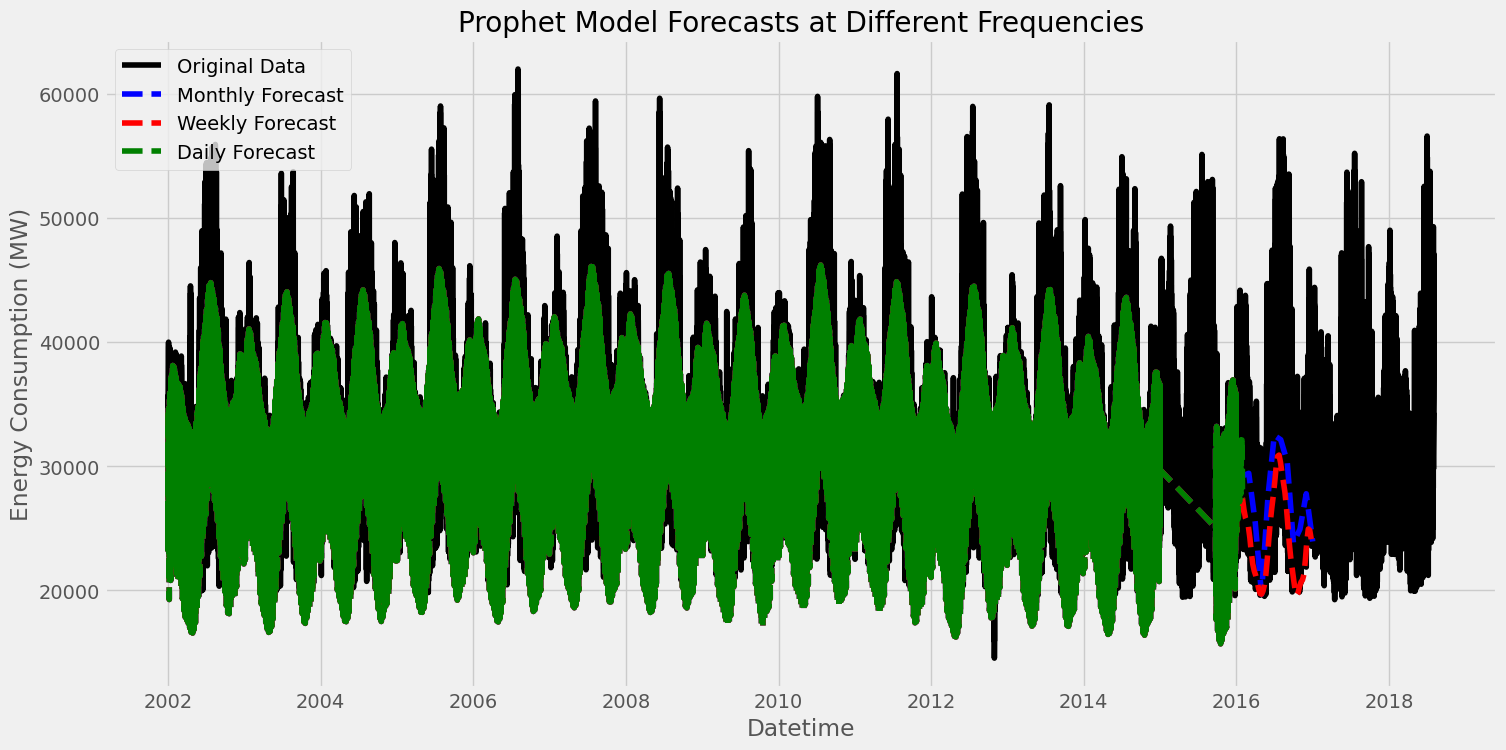

In [29]:
# Plot forecasts
plt.figure(figsize=(16, 8))

# Plot original data
plt.plot(prophet_df['ds'], prophet_df['y'], label='Original Data', color='black')

# Plot monthly forecast
plt.plot(forecast_monthly['ds'], forecast_monthly['yhat'], label='Monthly Forecast', color='blue', linestyle='--')

# Plot weekly forecast
plt.plot(forecast_weekly['ds'], forecast_weekly['yhat'], label='Weekly Forecast', color='red', linestyle='--')

# Plot daily forecast
plt.plot(forecast_daily['ds'], forecast_daily['yhat'], label='Daily Forecast', color='green', linestyle='--')

plt.title('Prophet Model Forecasts at Different Frequencies')
plt.xlabel('Datetime')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.show()

# Visualization:
Present our forecasting results visually. Creating clear and informative visualizations, such as time series plots or prediction vs. actual plots, can enhance the understanding of our work.

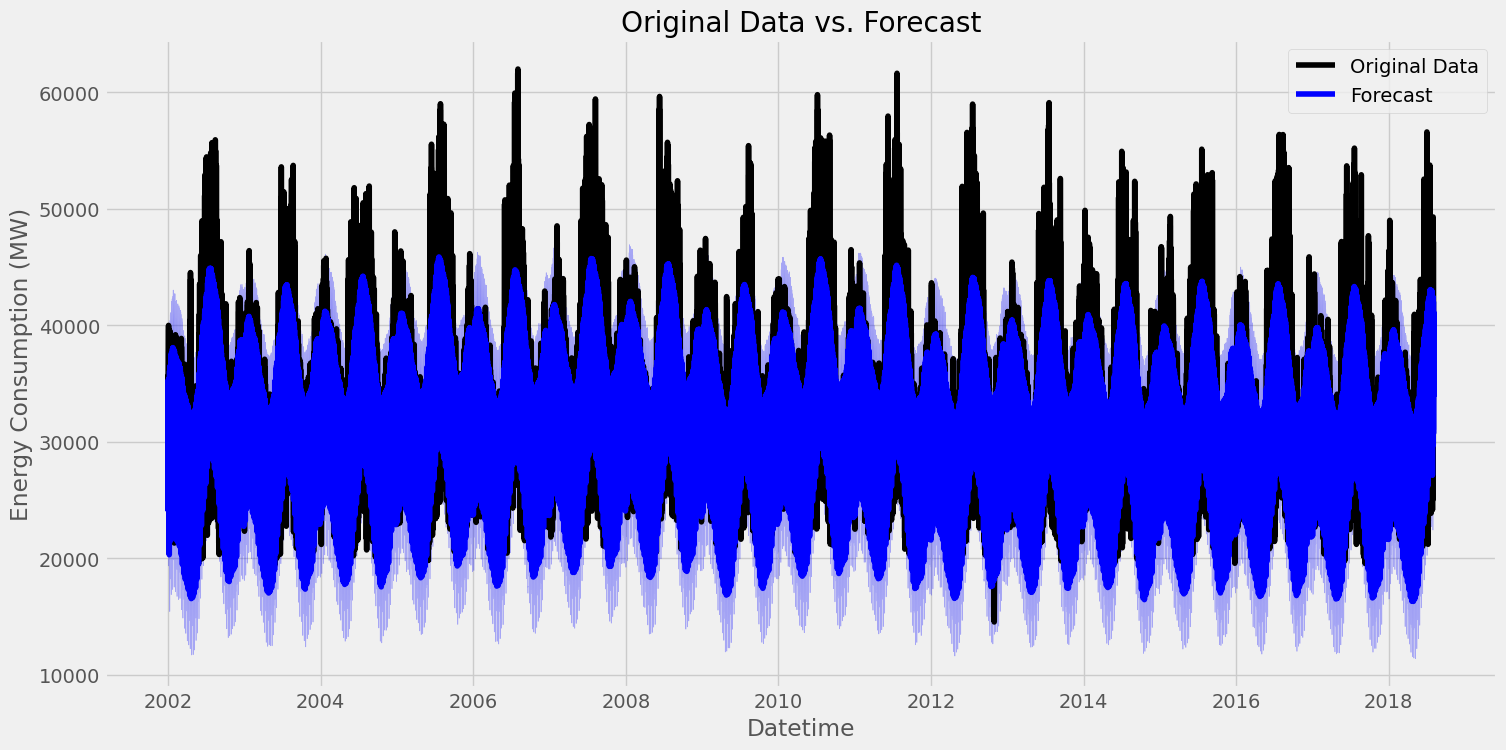

In [30]:
# Plot original data vs. forecast
plt.figure(figsize=(16, 8))
plt.plot(prophet_df['ds'], prophet_df['y'], label='Original Data', color='black')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='blue')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.3)
plt.title('Original Data vs. Forecast')
plt.xlabel('Datetime')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.show()

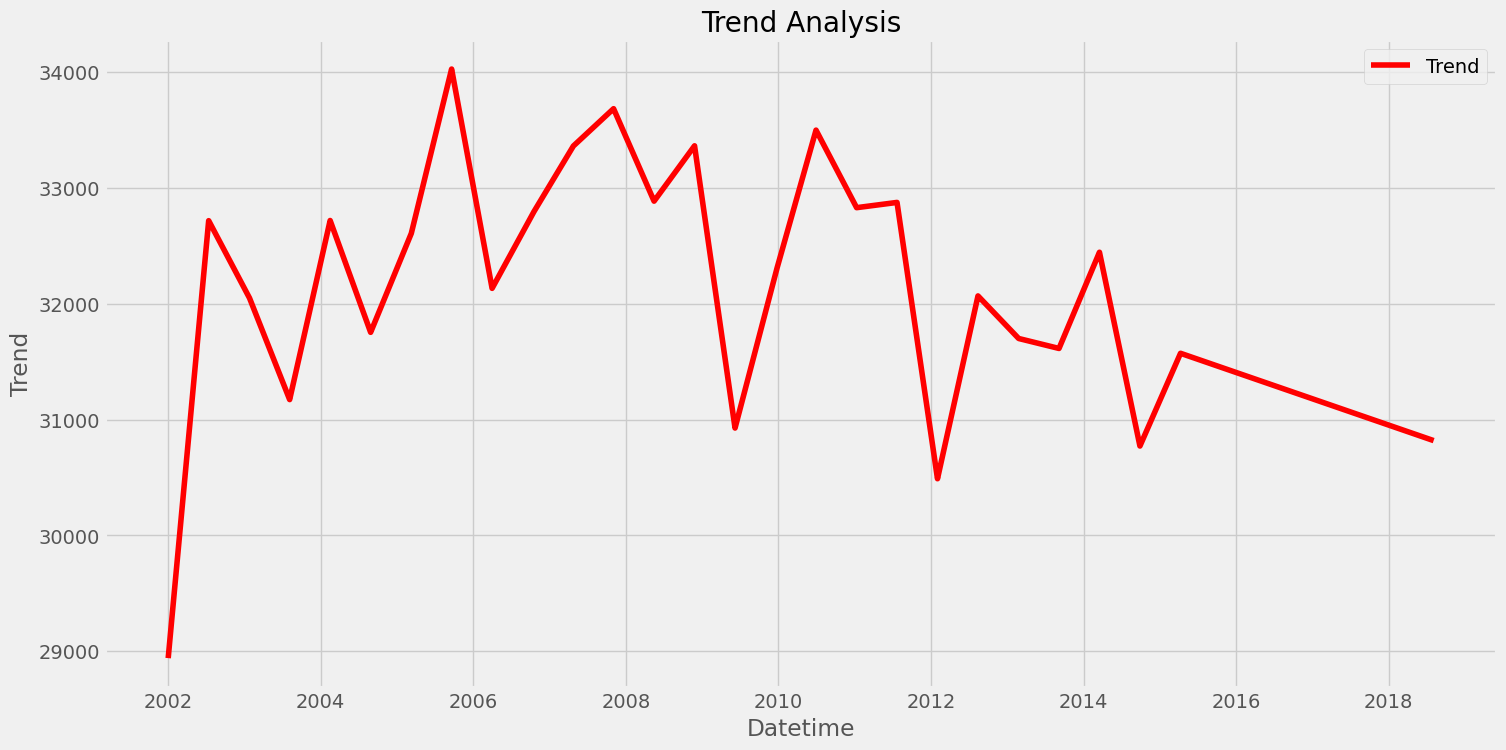

In [31]:
# Trend analysis
plt.figure(figsize=(16, 8))
plt.plot(forecast['ds'], forecast['trend'], label='Trend', color='red')
plt.title('Trend Analysis')
plt.xlabel('Datetime')
plt.ylabel('Trend')
plt.legend()
plt.show()

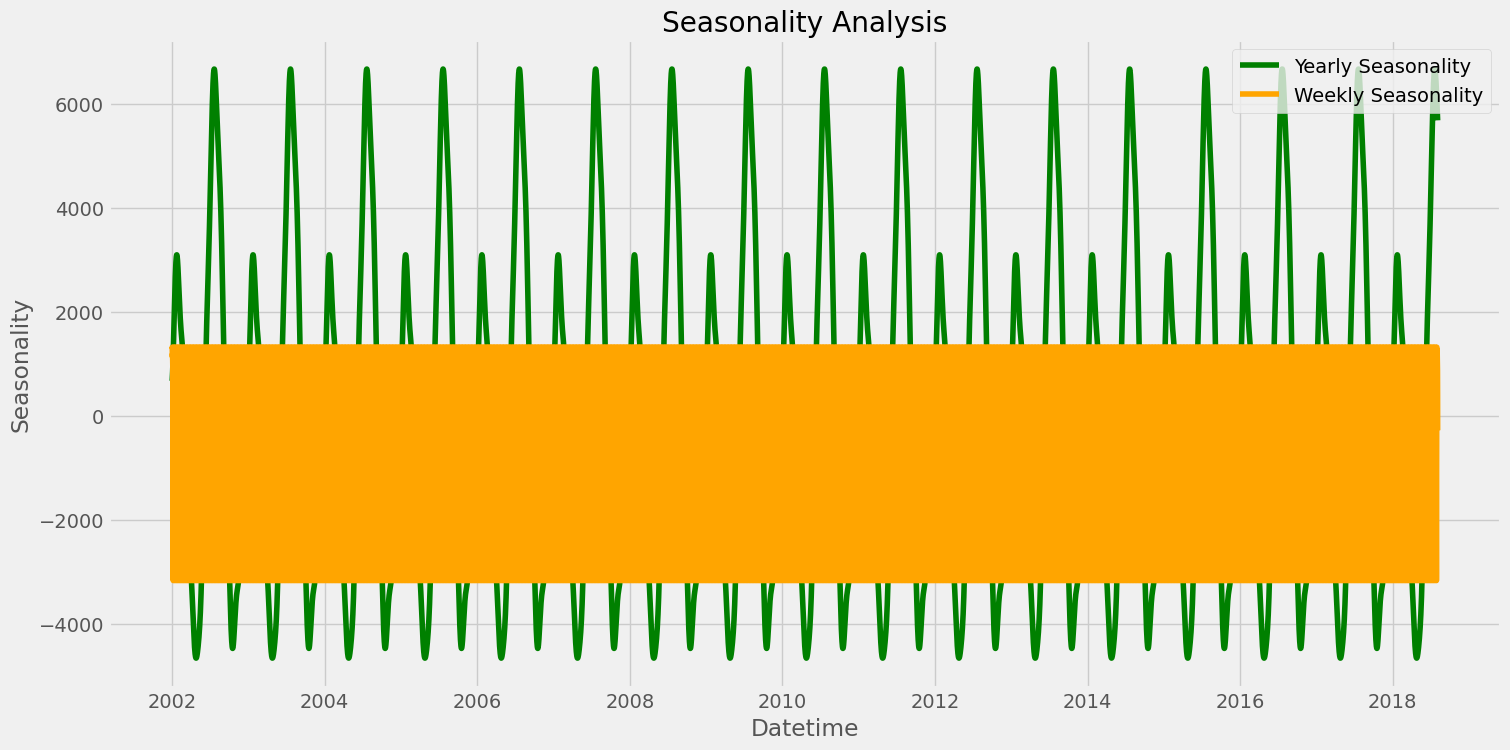

In [32]:
# Seasonality analysis
plt.figure(figsize=(16, 8))
plt.plot(forecast['ds'], forecast['yearly'], label='Yearly Seasonality', color='green')
plt.plot(forecast['ds'], forecast['weekly'], label='Weekly Seasonality', color='orange')
plt.title('Seasonality Analysis')
plt.xlabel('Datetime')
plt.ylabel('Seasonality')
plt.legend()
plt.show()

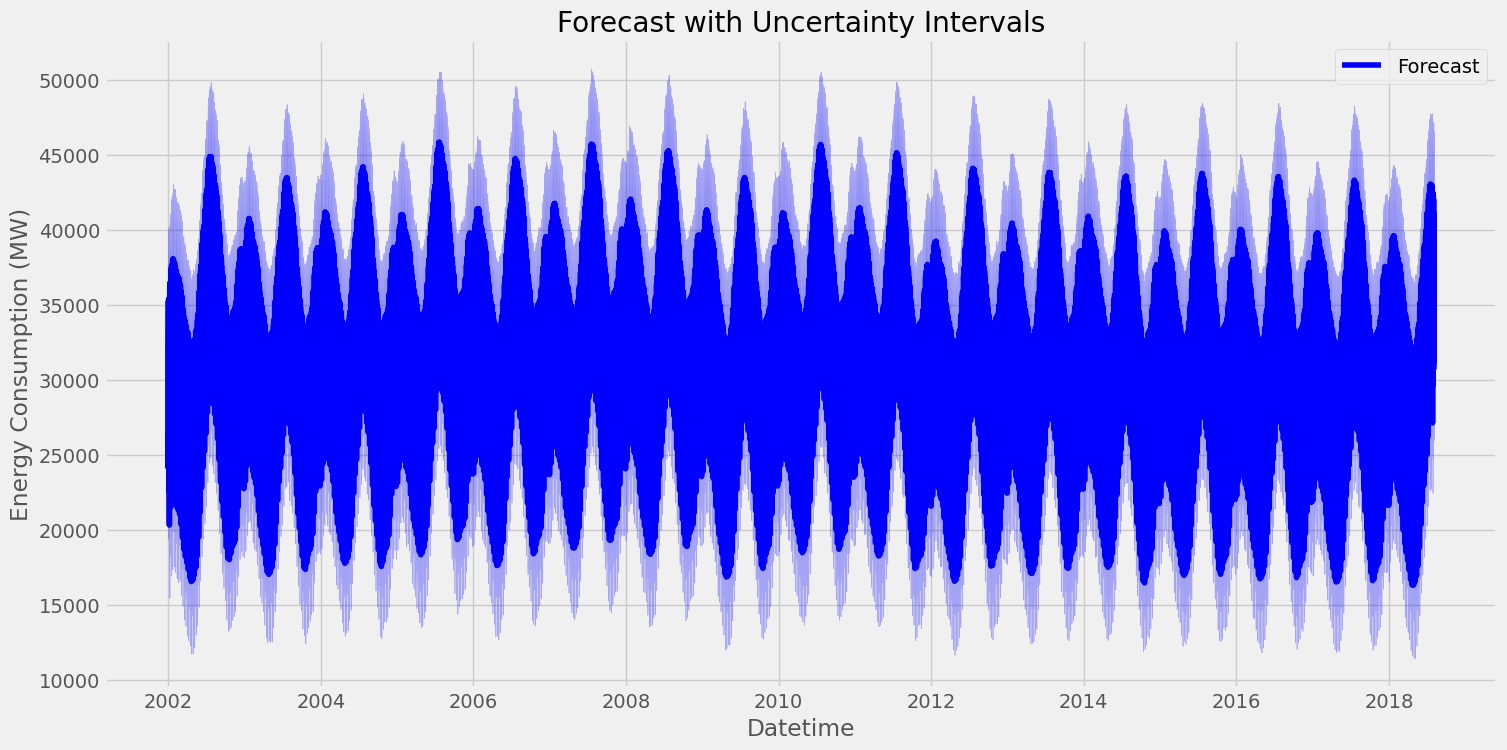

In [33]:
# Uncertainty intervals
plt.figure(figsize=(16, 8))
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='blue')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.3)
plt.title('Forecast with Uncertainty Intervals')
plt.xlabel('Datetime')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.show()

# THE END 